## 1. Data Preprocessing

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import ast
import re
from collections import Counter
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
! pip install imbalanced-learn
from imblearn.over_sampling import SMOTE

Load and Inspect the Dataset

In [ ]:

# Load the merged dataset
data = pd.read_csv("merged_reddit_discord_data.csv")

# Inspect the first few rows
print("Dataset Preview:")
print(data.head())

# Check the shape of the dataset
print(f"Dataset Shape: {data.shape}")

# Check for missing values
print("Missing Values:")
print(data.isnull().sum())

Dataset Preview:
                                                Text            Timestamp  \
0  ['Damn ATT, Verizon, Cisco, social security, a...  2024-12-30 23:15:22   
1  ['« NASA’s Voyager 2 flyby of Uranus decades a...  2024-12-30 21:23:56   
2  ['AI in war raises concerns.', 'When it comes ...  2024-12-30 20:23:18   
3  ['Creativity and problem-solving abilities, de...  2024-12-30 19:54:32   
4  ['This is generic victoza, which has been out ...  2024-12-30 18:41:36   

               Author  Source  \
0          lurker_bee  Reddit   
1              fchung  Reddit   
2         MetaKnowing  Reddit   
3  No-Information6622  Reddit   
4          Peter55667  Reddit   

                                               Topic  
0  Cisco Confirms Authenticity of Data After Seco...  
1  Mining old data from NASA’s Voyager 2 solves s...  
2  Israel built an ‘AI factory’ for war. It unlea...  
3  Developer fires entire team for AI, now ends u...  
4  FDA Approves First Generic of Once-Daily GL

Handle Missing Values

In [ ]:
# Drop rows where 'Text' is missing
data = data.dropna(subset=['Text'])

# Fill missing values in the 'Topic' column for Discord data with 'Unknown'
data['Author'] = data['Author'].fillna('Unknown')

# Check again for missing values
print("Missing Values After Handling:")
print(data.isnull().sum())

Missing Values After Handling:
Text         0
Timestamp    0
Author       0
Source       0
Topic        0
dtype: int64


Remove Duplicates

In [ ]:
# Remove duplicate rows
data = data.drop_duplicates()

# Confirm removal
print(f"Dataset Shape After Removing Duplicates: {data.shape}")

Dataset Shape After Removing Duplicates: (13856, 5)


Flatten the Comments from the reddit source

In [ ]:

# Load the data
reddit_data = data[data['Source'] == 'Reddit']

# Convert the 'Text' column from string to list
def convert_to_list(text):
    try:
        return ast.literal_eval(text) if isinstance(text, str) else text
    except (ValueError, SyntaxError):
        return []

reddit_data['Text'] = reddit_data['Text'].apply(convert_to_list)

# Explode the comments (create a row for each comment)
reddit_data = reddit_data.explode('Text', ignore_index=True)

# Preview the modified data
print(reddit_data.head())

                                                Text            Timestamp  \
0  Damn ATT, Verizon, Cisco, social security, adm...  2024-12-30 23:15:22   
1  « NASA’s Voyager 2 flyby of Uranus decades ago...  2024-12-30 21:23:56   
2  Maybe they can for uranus. But no data can sol...  2024-12-30 21:23:56   
3  Reference: Jasinski, J.M., Cochrane, C.J., Jia...  2024-12-30 21:23:56   
4                         AI in war raises concerns.  2024-12-30 20:23:18   

        Author  Source                                              Topic  
0   lurker_bee  Reddit  Cisco Confirms Authenticity of Data After Seco...  
1       fchung  Reddit  Mining old data from NASA’s Voyager 2 solves s...  
2       fchung  Reddit  Mining old data from NASA’s Voyager 2 solves s...  
3       fchung  Reddit  Mining old data from NASA’s Voyager 2 solves s...  
4  MetaKnowing  Reddit  Israel built an ‘AI factory’ for war. It unlea...  


C:\Users\Hp\AppData\Local\Temp\ipykernel_15076\1214777632.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reddit_data['Text'] = reddit_data['Text'].apply(convert_to_list)


 Clean the Individual Comments

In [ ]:
# Clean the text column after exploding
def clean_comment(comment):
    if isinstance(comment, str):
        comment = comment.strip()
        comment = comment.replace('\n', ' ')  # Remove newlines
    return comment

reddit_data['Text'] = reddit_data['Text'].apply(clean_comment)

# Remove rows where 'Text' is empty or NaN after cleaning
reddit_data = reddit_data.dropna(subset=['Text'])
reddit_data = reddit_data[reddit_data['Text'].str.strip() != '']

# Preview the cleaned comments
print("Cleaned Reddit Comments:")
print(reddit_data.head())

Cleaned Reddit Comments:
                                                Text            Timestamp  \
0  Damn ATT, Verizon, Cisco, social security, adm...  2024-12-30 23:15:22   
1  « NASA’s Voyager 2 flyby of Uranus decades ago...  2024-12-30 21:23:56   
2  Maybe they can for uranus. But no data can sol...  2024-12-30 21:23:56   
3  Reference: Jasinski, J.M., Cochrane, C.J., Jia...  2024-12-30 21:23:56   
4                         AI in war raises concerns.  2024-12-30 20:23:18   

        Author  Source                                              Topic  
0   lurker_bee  Reddit  Cisco Confirms Authenticity of Data After Seco...  
1       fchung  Reddit  Mining old data from NASA’s Voyager 2 solves s...  
2       fchung  Reddit  Mining old data from NASA’s Voyager 2 solves s...  
3       fchung  Reddit  Mining old data from NASA’s Voyager 2 solves s...  
4  MetaKnowing  Reddit  Israel built an ‘AI factory’ for war. It unlea...  


In [ ]:
# Check if Reddit rows are still present in the main dataset
reddit_rows_count = data[data['Source'] == 'Reddit'].shape[0]
print(f"Number of Reddit rows in the main dataset: {reddit_rows_count}")

Number of Reddit rows in the main dataset: 649


In [ ]:
# Remove rows with 'Source' == 'Reddit' from the main dataset
data = data[data['Source'] != 'Reddit'].reset_index(drop=True)
print("Original Reddit rows removed from the main dataset.")
# Concatenate the cleaned Reddit data with the main dataset
data = pd.concat([data, reddit_data], ignore_index=True)

# Reset the index for the combined dataset
data.reset_index(drop=True, inplace=True)

# Save the updated main dataset
data.to_csv("merged_dataset.csv", index=False)
print("Merged dataset saved as 'merged_dataset.csv'.")
# Preview the merged dataset
print("Merged Dataset Preview:")
print(data.head())

Original Reddit rows removed from the main dataset.
Merged dataset saved as 'merged_dataset.csv'.
Merged Dataset Preview:
                                                Text  \
0  *The mother of learning, is repetition.*\n*The...   
1                                                🤨 ?   
2  Only two things can do that. <a:FP_StarSparkle...   
3  Fair enough. Will this take me from "zero to h...   
4                           It's your time to waste.   

                          Timestamp     Author   Source    Topic  
0  2024-12-30T17:32:53.427000+00:00   The Blue  Discord  Unknown  
1  2024-12-30T17:32:10.251000+00:00  Wolverine  Discord  Unknown  
2  2024-12-30T17:31:35.458000+00:00   The Blue  Discord  Unknown  
3  2024-12-30T17:30:50.323000+00:00  Wolverine  Discord  Unknown  
4  2024-12-30T17:30:03.453000+00:00   The Blue  Discord  Unknown  


Normalize Text Data

In [ ]:


# Normalize the 'Text' column
def normalize_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\s+', ' ', text)  # Remove extra whitespace
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    return text

data['Text'] = data['Text'].apply(normalize_text)

# Preview the cleaned text
print("Normalized Text:")
print(data['Text'].head())

Normalized Text:
0    the mother of learning is repetition the fathe...
1                                                     
2    only two things can do that afp_starsparkle940...
3    fair enough will this take me from zero to her...
4                               its your time to waste
Name: Text, dtype: object


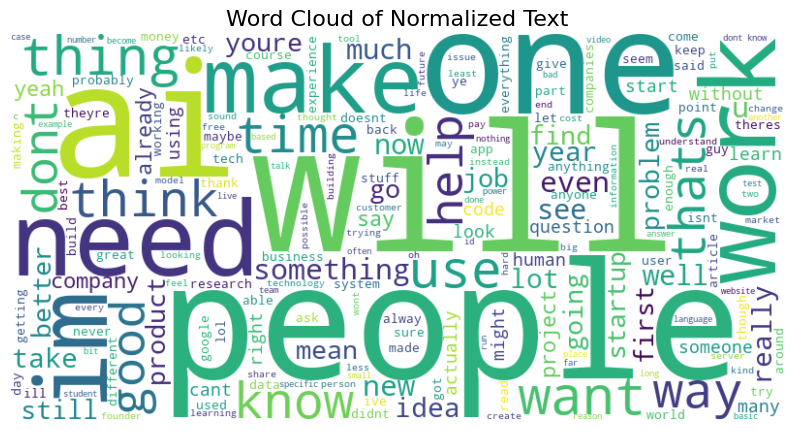

In [ ]:


# Combine all text for the word cloud
all_text = ' '.join(data['Text'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Normalized Text", fontsize=16)
plt.show()

In [ ]:
# # Save the preprocessed dataset
# data.to_csv("preprocessed_dataset.csv", index=False)
# print("Preprocessed dataset saved as 'preprocessed_dataset.csv'.")

## 2. Text Processing

In [ ]:

# Remove URLs from the text
def remove_urls(text):
    return re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)

data['Text'] = data['Text'].apply(remove_urls)

# Check the cleaned text
print(data['Text'].head())

0    the mother of learning is repetition the fathe...
1                                                     
2    only two things can do that afp_starsparkle940...
3    fair enough will this take me from zero to her...
4                               its your time to waste
Name: Text, dtype: object


In [ ]:
# Remove special characters
def remove_special_chars(text):
    return re.sub(r"[^a-zA-Z0-9\s]", "", text)

data['Text'] = data['Text'].apply(remove_special_chars)

# Check the cleaned text
print(data['Text'].head())

0    the mother of learning is repetition the fathe...
1                                                     
2    only two things can do that afpstarsparkle9407...
3    fair enough will this take me from zero to her...
4                               its your time to waste
Name: Text, dtype: object


In [ ]:
# Convert text to lowercase
data['Text'] = data['Text'].str.lower()

# Check the cleaned text
print(data['Text'].head())

0    the mother of learning is repetition the fathe...
1                                                     
2    only two things can do that afpstarsparkle9407...
3    fair enough will this take me from zero to her...
4                               its your time to waste
Name: Text, dtype: object


In [ ]:

# Tokenize text
data['Tokens'] = data['Text'].apply(word_tokenize)

# Check tokenized text
print(data[['Text', 'Tokens']].head())

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


                                                Text  \
0  the mother of learning is repetition the fathe...   
1                                                      
2  only two things can do that afpstarsparkle9407...   
3  fair enough will this take me from zero to her...   
4                             its your time to waste   

                                              Tokens  
0  [the, mother, of, learning, is, repetition, th...  
1                                                 []  
2  [only, two, things, can, do, that, afpstarspar...  
3  [fair, enough, will, this, take, me, from, zer...  
4                       [its, your, time, to, waste]  


In [ ]:

stop_words = set(stopwords.words("english"))

# Remove stopwords
def remove_stopwords(tokens):
    return [word for word in tokens if word not in stop_words]

data['Tokens'] = data['Tokens'].apply(remove_stopwords)

# Check cleaned tokens
print(data[['Text', 'Tokens']].head())

                                                Text  \
0  the mother of learning is repetition the fathe...   
1                                                      
2  only two things can do that afpstarsparkle9407...   
3  fair enough will this take me from zero to her...   
4                             its your time to waste   

                                            Tokens  
0     [mother, learning, repetition, father, pain]  
1                                               []  
2  [two, things, afpstarsparkle940749986352742430]  
3          [fair, enough, take, zero, hero, think]  
4                                    [time, waste]  

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:

lemmatizer = WordNetLemmatizer()

# Lemmatize tokens
def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(word) for word in tokens]

data['Tokens'] = data['Tokens'].apply(lemmatize_tokens)

# Check lemmatized tokens
print(data[['Text', 'Tokens']].head())

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Hp\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


                                                Text  \
0  the mother of learning is repetition the fathe...   
1                                                      
2  only two things can do that afpstarsparkle9407...   
3  fair enough will this take me from zero to her...   
4                             its your time to waste   

                                           Tokens  
0    [mother, learning, repetition, father, pain]  
1                                              []  
2  [two, thing, afpstarsparkle940749986352742430]  
3         [fair, enough, take, zero, hero, think]  
4                                   [time, waste]  


In [ ]:
# Rejoin tokens into a single string
data['Cleaned_Text'] = data['Tokens'].apply(lambda tokens: " ".join(tokens))

# Check final cleaned text
print(data[['Text', 'Cleaned_Text']].head())

                                                Text  \
0  the mother of learning is repetition the fathe...   
1                                                      
2  only two things can do that afpstarsparkle9407...   
3  fair enough will this take me from zero to her...   
4                             its your time to waste   

                                 Cleaned_Text  
0      mother learning repetition father pain  
1                                              
2  two thing afpstarsparkle940749986352742430  
3            fair enough take zero hero think  
4                                  time waste  


Most Common Words:
[('like', 1752), ('ai', 1231), ('get', 1167), ('dont', 1164), ('im', 1162), ('people', 1157), ('one', 1075), ('need', 1048), ('would', 1030), ('work', 925)]


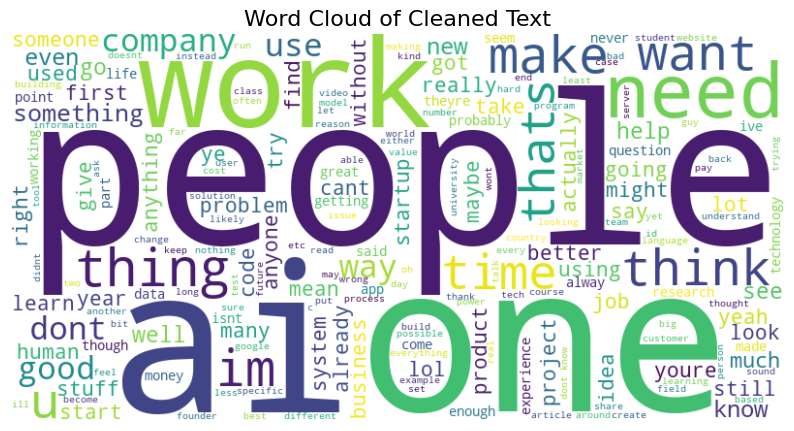

In [ ]:

# Generate a frequency distribution of words
all_words = [word for tokens in data['Tokens'] for word in tokens]
word_counts = Counter(all_words)

# Display the most common words
print("Most Common Words:")
print(word_counts.most_common(10))

# Generate and visualize a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(all_words))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Word Cloud of Cleaned Text", fontsize=16)
plt.show()


In [ ]:
# Extend the default stopwords list
custom_stopwords = set(stopwords.words("english"))
custom_stopwords.update(["like", "get", "dont", "im", "would", "need", "one", "people", "work"])  # Add custom words

# Remove custom stopwords
data['Tokens'] = data['Tokens'].apply(lambda tokens: [word for word in tokens if word not in custom_stopwords])

# Regenerate word frequency distribution
all_words = [word for tokens in data['Tokens'] for word in tokens]
word_counts = Counter(all_words)

# Display updated most common words
print("Most Common Words After Stopword Removal:")
print(word_counts.most_common(200))

Most Common Words After Stopword Removal:
[('ai', 1231), ('know', 856), ('time', 847), ('make', 845), ('want', 797), ('thing', 792), ('good', 749), ('also', 730), ('think', 715), ('year', 713), ('company', 673), ('thats', 662), ('use', 656), ('way', 656), ('help', 635), ('even', 614), ('could', 596), ('something', 576), ('much', 574), ('really', 572), ('u', 569), ('new', 544), ('see', 541), ('go', 525), ('well', 494), ('idea', 483), ('youre', 482), ('take', 480), ('first', 446), ('lot', 434), ('right', 431), ('problem', 423), ('going', 416), ('still', 409), ('startup', 407), ('find', 403), ('mean', 401), ('better', 390), ('say', 384), ('job', 382), ('product', 376), ('many', 376), ('someone', 375), ('project', 371), ('already', 368), ('yeah', 365), ('cant', 365), ('question', 356), ('look', 355), ('using', 354), ('sure', 352), ('business', 342), ('start', 340), ('got', 338), ('human', 338), ('might', 328), ('guy', 328), ('code', 324), ('actually', 324), ('without', 318), ('anyone', 316

In [ ]:
# # Extend the custom stopwords list further
# additional_stopwords = [
#     "know", "time", "make", "want", "thing", "also", "think", "year",
#     "help", "even", "could", "much", "really", "new", "see", "go",
#     "lot", "still", "way", "first", 'thats', 'something', 'u'
# ]

# custom_stopwords.update(additional_stopwords)

# # Remove updated stopwords
# data['Tokens'] = data['Tokens'].apply(lambda tokens: [word for word in tokens if word not in custom_stopwords])

# # Regenerate word frequency distribution
# all_words = [word for tokens in data['Tokens'] for word in tokens]
# word_counts = Counter(all_words)

# # Display updated most common words
# print("Most Common Words After Additional Stopword Removal:")
# print(word_counts.most_common(200))

In [ ]:
# Check for null or empty values in the 'Text' column
null_count = data['Text'].isnull().sum()
empty_count = (data['Text'].str.strip() == '').sum()

print(f"Number of null rows in 'Text': {null_count}")
print(f"Number of empty rows in 'Text': {empty_count}")
print(f"Dataset size after cleaning: {data.shape}")
# Remove rows with null or empty 'Text'
data = data.dropna(subset=['Text'])  # Drop null values
data = data[data['Text'].str.strip() != '']  # Drop empty strings

# Verify the changes
print(f"Dataset size after cleaning: {data.shape}")

Number of null rows in 'Text': 0
Number of empty rows in 'Text': 384
Dataset size after cleaning: (17606, 7)
Dataset size after cleaning: (17222, 7)


VADER for labeling

In [ ]:


# Download the VADER lexicon
nltk.download('vader_lexicon')

# Initialize the VADER sentiment analyzer
vader_analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Hp\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
# Apply VADER sentiment analysis to the 'Text' column
data['VADER_Sentiment'] = data['Text'].apply(lambda x: vader_analyzer.polarity_scores(x)['compound'])

# Preview the results
print(data[['Text', 'VADER_Sentiment']].head())


                                                Text  VADER_Sentiment
0  the mother of learning is repetition the fathe...          -0.5106
2  only two things can do that afpstarsparkle9407...           0.0000
3  fair enough will this take me from zero to her...           0.7096
4                             its your time to waste          -0.4215
5  true  i am not new to programming so i underst...           0.6808


In [ ]:
# Define sentiment categories based on the compound score
def categorize_sentiment(compound_score):
    if compound_score >= 0.1:
        return 'Positive'
    elif compound_score <= -0.1:
        return 'Negative'
    else:
        return 'Neutral'

# Apply categorization
data['Sentiment_Label'] = data['VADER_Sentiment'].apply(categorize_sentiment)

# Preview the results
print(data[['Text', 'VADER_Sentiment', 'Sentiment_Label']].head())

                                                Text  VADER_Sentiment  \
0  the mother of learning is repetition the fathe...          -0.5106   
2  only two things can do that afpstarsparkle9407...           0.0000   
3  fair enough will this take me from zero to her...           0.7096   
4                             its your time to waste          -0.4215   
5  true  i am not new to programming so i underst...           0.6808   

  Sentiment_Label  
0        Negative  
2         Neutral  
3        Positive  
4        Negative  
5        Positive  


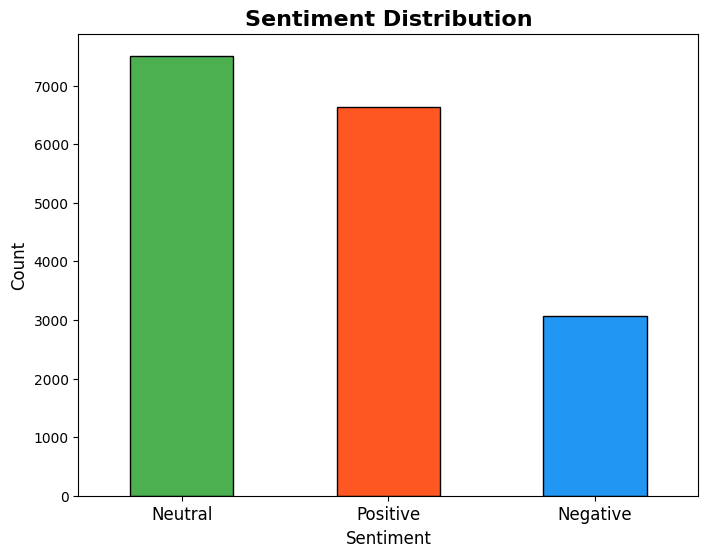

In [ ]:

# Count sentiment labels
sentiment_counts = data['Sentiment_Label'].value_counts()

# Plot the distribution
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=['#4CAF50', '#FF5722', '#2196F3'], edgecolor='black')
plt.title('Sentiment Distribution', fontsize=16, weight='bold')
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0, fontsize=12)
plt.show()

## 3. Exploratory Data Analysis (EDA)

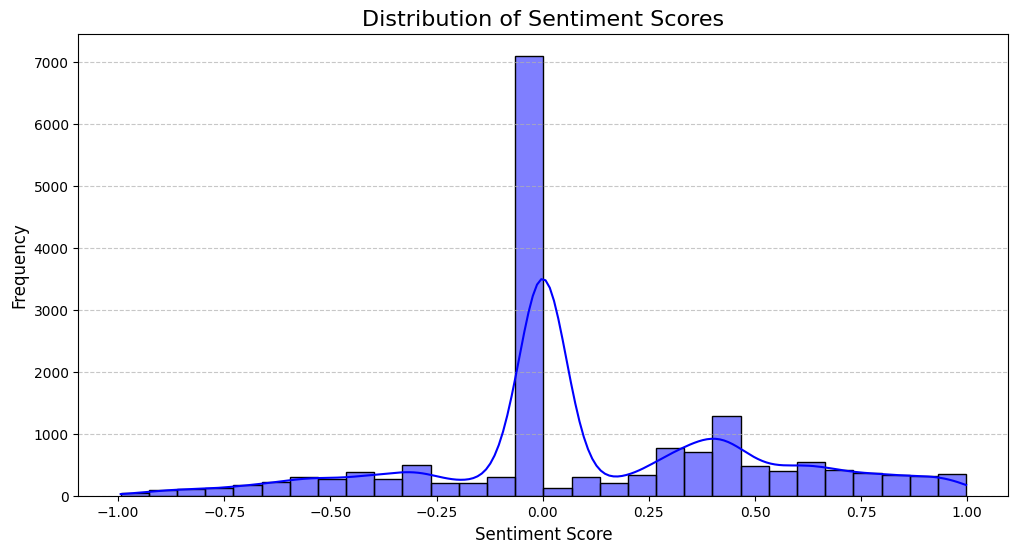

In [ ]:
# Plot the distribution of sentiment scores

plt.figure(figsize=(12, 6))
sns.histplot(data['VADER_Sentiment'], kde=True, bins=30, color='blue')
plt.title('Distribution of Sentiment Scores', fontsize=16)
plt.xlabel('Sentiment Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

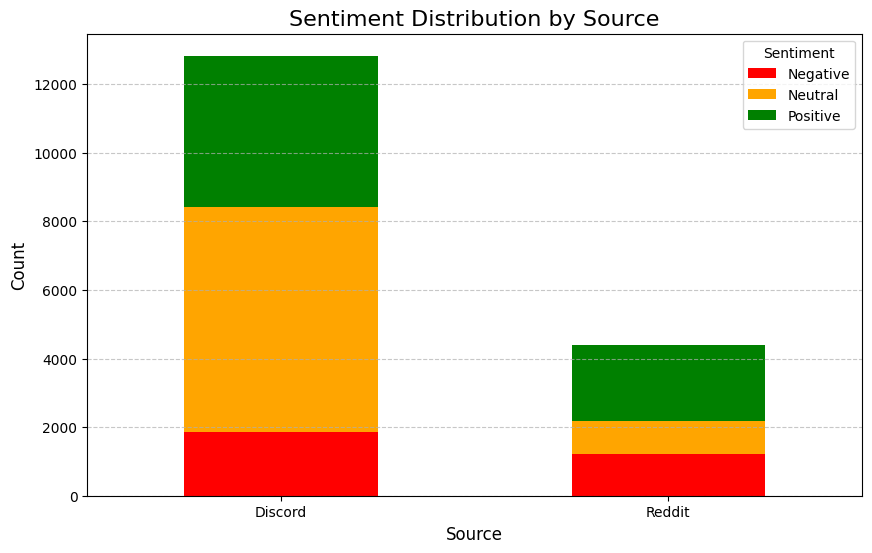

In [ ]:
# Group by Source and Sentiment_Label
source_sentiment_counts = data.groupby(['Source', 'Sentiment_Label']).size().unstack()

# Plot a stacked bar chart
source_sentiment_counts.plot(kind='bar', stacked=True, figsize=(10, 6), color=['red', 'orange', 'green'])
plt.title('Sentiment Distribution by Source', fontsize=16)
plt.xlabel('Source', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Sentiment', loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


N-GRAM ANALYSIS

**LOGISTIC REGRESSION**

ENCODING

In [ ]:
# Define sentiment encoding
sentiment_mapping = {
    'Positive': 1,
    'Neutral': 0,
    'Negative': -1
}
# Encode the sentiment labels
data['Sentiment_Encoded'] = data['Sentiment_Label'].map(sentiment_mapping)

# Verify the encoding
print(data[['Sentiment_Label', 'Sentiment_Encoded']].head())


  Sentiment_Label  Sentiment_Encoded
0        Negative                 -1
2         Neutral                  0
3        Positive                  1
4        Negative                 -1
5        Positive                  1


In [ ]:
# Check for missing values in the encoded column
missing_encoded = data['Sentiment_Encoded'].isnull().sum()
print(f"Number of missing sentiment labels: {missing_encoded}")

# Drop rows with missing sentiment encoding if needed
data = data.dropna(subset=['Sentiment_Encoded'])


Number of missing sentiment labels: 0


In [ ]:
# Update TF-IDF Vectorizer to exclude numbers
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    stop_words='english',
    token_pattern=r'(?u)\b[a-zA-Z_][a-zA-Z0-9_]+\b'  # Exclude tokens that are purely numbers
)

# Refit and transform
tfidf_matrix = tfidf_vectorizer.fit_transform(data['Text'])

# Get updated feature names
feature_names = tfidf_vectorizer.get_feature_names_out()

In [ ]:
# Apply TF-IDF to the 'Text' column
tfidf_matrix = tfidf_vectorizer.fit_transform(data['Text'])

# Convert to a dense DataFrame for better inspection (optional)
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(),
    columns=tfidf_vectorizer.get_feature_names_out()
)

# # Preview the resulting TF-IDF matrix
# print(tfidf_df.head())


In [ ]:
# # List top 10 TF-IDF features
# feature_names = tfidf_vectorizer.get_feature_names_out()
# print(f"Top TF-IDF features: {feature_names[:10]}")

In [ ]:
# Declare the target variable
y = data['Sentiment_Label']

# Check the distribution of the target variable
print("Target Variable Distribution:")
print(y.value_counts())

Target Variable Distribution:
Sentiment_Label
Neutral     7510
Positive    6639
Negative    3073
Name: count, dtype: int64


In [ ]:

# Encode labels to numeric values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Map of encoded values
print("Label Encoding Mapping:")
print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

# Use y_encoded as the target variable


Label Encoding Mapping:
{'Negative': 0, 'Neutral': 1, 'Positive': 2}


In [ ]:


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, y_encoded, test_size=0.2, random_state=42)

print(f"Training Set Size: {X_train.shape}")
print(f"Testing Set Size: {X_test.shape}")


Training Set Size: (13777, 5000)
Testing Set Size: (3445, 5000)


In [ ]:

# Check the class distribution before SMOTE
print("Class Distribution Before SMOTE:")
print(pd.Series(y_train).value_counts())


Class Distribution Before SMOTE:
1    6012
2    5300
0    2465
Name: count, dtype: int64


In [ ]:
# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check the class distribution after SMOTE
print("\nClass Distribution After SMOTE:")
print(pd.Series(y_train_resampled).value_counts())


Class Distribution After SMOTE:
1    6012
2    6012
0    6012
Name: count, dtype: int64


In [ ]:
print(f"Original Training Set Size: {X_train.shape}")
print(f"Resampled Training Set Size: {X_train_resampled.shape}")


Original Training Set Size: (13777, 5000)
Resampled Training Set Size: (18036, 5000)


In [ ]:

# Train a Logistic Regression model
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_resampled, y_train_resampled)

# Evaluate the model
y_pred = model.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.63      0.59       608
           1       0.83      0.85      0.84      1498
           2       0.87      0.79      0.83      1339

    accuracy                           0.79      3445
   macro avg       0.75      0.76      0.75      3445
weighted avg       0.80      0.79      0.79      3445



In [ ]:
# Check the shape of the TF-IDF matrix
print(f"TF-IDF Matrix Shape: {tfidf_matrix.shape}")


TF-IDF Matrix Shape: (17222, 5000)


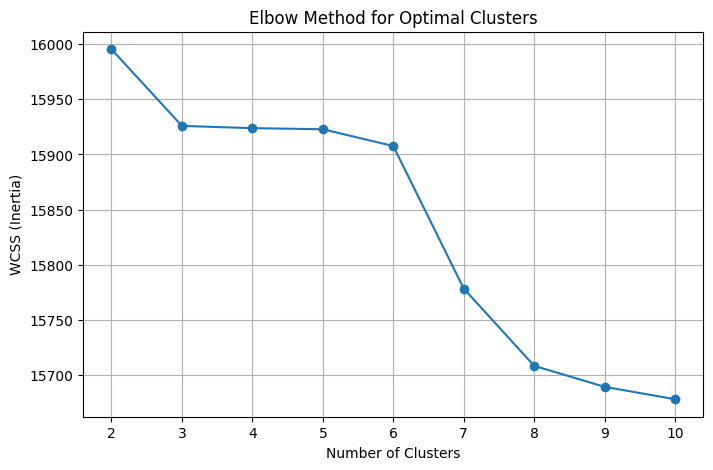

In [ ]:
wcss = []  # Within-cluster sum of squares
for i in range(2, 11):  # Try between 2 and 10 clusters
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(tfidf_matrix)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), wcss, marker='o')
plt.title("Elbow Method for Optimal Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS (Inertia)")
plt.grid()
plt.show()


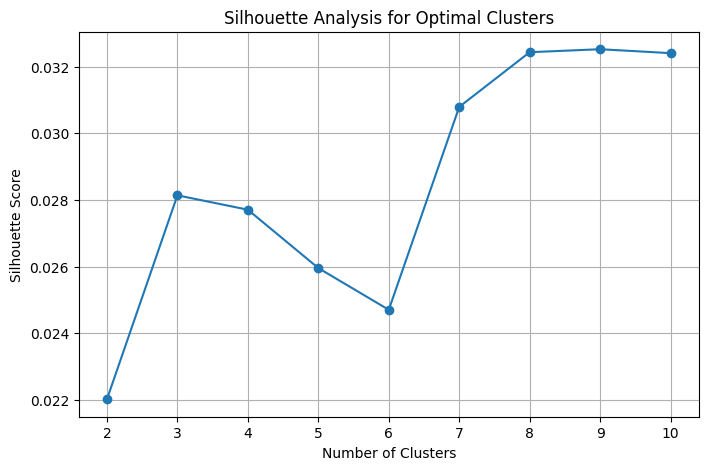

In [ ]:
silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    labels = kmeans.fit_predict(tfidf_matrix)
    score = silhouette_score(tfidf_matrix, labels)
    silhouette_scores.append(score)

# Plot Silhouette Scores
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title("Silhouette Analysis for Optimal Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.grid()
plt.show()


In [ ]:
# Apply K-Means
n_clusters = 6  # Replace with your optimal number
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(tfidf_matrix)

# Add the cluster labels to the original dataset
data['Cluster'] = cluster_labels


In [ ]:
print(data['Cluster'].value_counts())


Cluster
2    16922
1      139
5      113
0       44
3        3
4        1
Name: count, dtype: int64


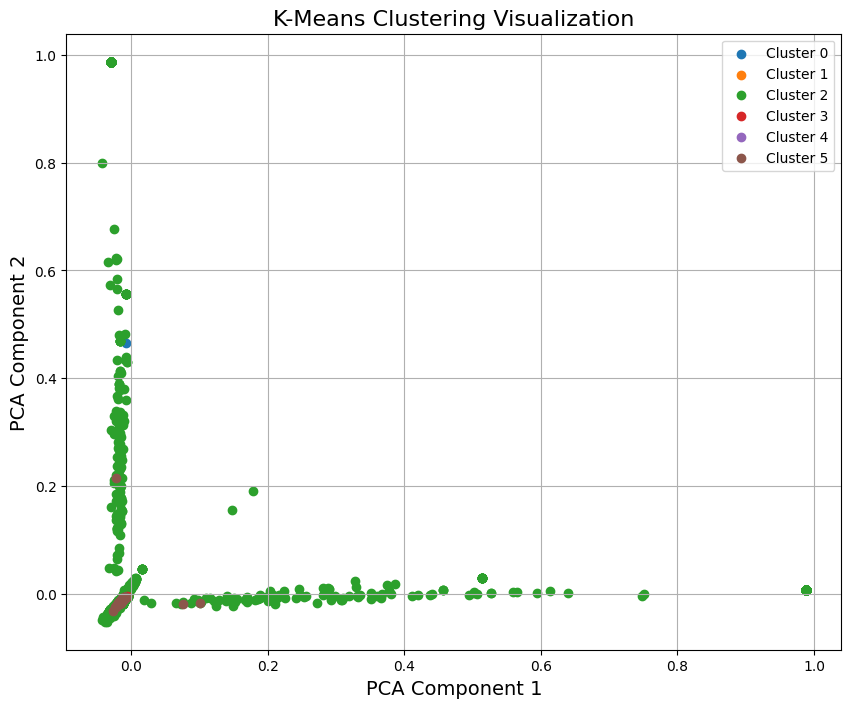

In [ ]:

# Reduce dimensions for visualization
pca = PCA(n_components=2, random_state=42)
reduced_data = pca.fit_transform(tfidf_matrix.toarray())

# Scatter plot of clusters
plt.figure(figsize=(10, 8))
for cluster in range(n_clusters):
    cluster_data = reduced_data[cluster_labels == cluster]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f"Cluster {cluster}")

plt.title("K-Means Clustering Visualization", fontsize=16)
plt.xlabel("PCA Component 1", fontsize=14)
plt.ylabel("PCA Component 2", fontsize=14)
plt.legend()
plt.grid()
plt.show()


In [ ]:
silhouette_avg = silhouette_score(tfidf_matrix, cluster_labels)
print(f"Average Silhouette Score: {silhouette_avg:.2f}")


Average Silhouette Score: 0.02


In [ ]:

# Get top terms per cluster
terms = tfidf_vectorizer.get_feature_names_out()
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

for i in range(n_clusters):
    print(f"Cluster {i} Top Terms:")
    top_terms = [terms[ind] for ind in order_centroids[i, :20]]
    print(", ".join(top_terms))


Cluster 0 Top Terms:
yo, guys, welcome, sick, talk, tailwind, hello guys, late, fucking, sorry, reply, exactly, love, need, hello, focusing, form, focus building, formal, format
Cluster 1 Top Terms:
yes, sir, thats, does, lol, server, yes im, yes know, true, lot, like, elective, ultimately, bruh, sadly, library, nope, chemistry, enjoy, edit
Cluster 2 Top Terms:
like, just, im, hi, dont, hello, know, thats, yeah, ai, need, good, people, work, want, help, think, use, oh, time
Cluster 3 Top Terms:
john, surely, capitalism, examples, innovation, doing, apple, formula, forget, forgot, form, formal, format, forms, zoom, forprofit, forums, forward, fossil, foundation
Cluster 4 Top Terms:
review, goal, change, sure, formula, forever, forget, forgot, form, formal, format, forms, forum, forprofit, foreign, forums, forward, fossil, foundation, founded
Cluster 5 Top Terms:
school, high, high school, im, like, college, university, public, thats, ap, degree, student, just, grades, java, learn, calif

Model Evaluation

In [ ]:
cross_tab = pd.crosstab(data['Cluster'], data['Sentiment_Label'])
print(cross_tab)

Sentiment_Label  Negative  Neutral  Positive
Cluster                                     
0                       1       41         2
1                       3        1       135
2                    3049     7422      6451
3                       1        1         1
4                       0        0         1
5                      19       45        49


In [ ]:

feature_names = tfidf_vectorizer.get_feature_names_out()
coefficients = model.coef_
for i, label in enumerate(label_encoder.classes_):
    print(f"Top terms for {label}:")
    top_indices = coefficients[i].argsort()[-10:][::-1]
    print(", ".join([feature_names[idx] for idx in top_indices]))

Top terms for Negative:
ill, problem, wrong, bad, discord, fuck, hell, shit, stupid, dead
Top terms for Neutral:
hi, hello, yo, depends, wait, hey, hii, deleted, tag, yup
Top terms for Positive:
like, good, best, yes, better, pretty, help, yeah, love, thanks
